# Exploratory Data Analysis (EDA)

This notebook is for exploratory work only (not production code).

## Checklist
Run the sections below to cover:

- Overview of the data (shape, dtypes, samples)
- Summary statistics
- Distributions (numerical + categorical)
- Correlation analysis
- Missing values
- Outlier detection

## Data location
Place your dataset in `../data/raw/` (CSV/Parquet/Excel), or set `DATA_PATH` explicitly in the loading cell.

## Deliverable
At the end of this notebook there is a **Top 3–5 Insights** section. After running the notebook, keep your most important findings there.

In [1]:
# Core libraries
import os
from pathlib import Path

import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 5)

print("pandas:", pd.__version__)
print("numpy:", np.__version__)

pandas: 2.3.3
numpy: 2.0.2


## 1) Load data

This notebook expects a dataset file inside `../data/raw/`.

- Supported formats: `.csv`, `.parquet`, `.xlsx`
- If multiple files exist, the first one (sorted by name) will be loaded.
- You can also set `DATA_PATH` explicitly.

In [5]:
DATA_DIR = Path("..").resolve() / "data" / "raw"

# Explicitly set the main dataset file you placed in ../data/raw/
DATA_PATH = DATA_DIR / "data.csv"

# (Optional) Variable definitions file
DEFINITIONS_PATH = DATA_DIR / "Xente_Variable_Definitions.csv"

if not DATA_PATH.exists():
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}. Update DATA_PATH to your file name.")

print("Loading dataset:", DATA_PATH)

if DATA_PATH.suffix.lower() == ".csv":
    df = pd.read_csv(DATA_PATH)
elif DATA_PATH.suffix.lower() == ".parquet":
    df = pd.read_parquet(DATA_PATH)
elif DATA_PATH.suffix.lower() == ".xlsx":
    df = pd.read_excel(DATA_PATH)
else:
    raise ValueError(f"Unsupported file type: {DATA_PATH.suffix}")

print("Loaded df shape:", df.shape)
df.head()

Loading dataset: C:\Users\ELITEBOOK\Documents\Projects\AI_engineering\Credit Risk Probability Model for Alternative Data\data\raw\data.csv
Loaded df shape: (95662, 16)


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [ ]:
# To keep EDA responsive on larger datasets, we sample for expensive visualizations/correlations.
# (Summary stats and missingness are still computed on the full dataset.)
DF_PLOT_MAX_ROWS = 20000  # lower this if plots still feel slow (e.g., 5000)

if len(df) > DF_PLOT_MAX_ROWS:
    df_plot = df.sample(DF_PLOT_MAX_ROWS, random_state=42)
else:
    df_plot = df

print("df shape:", df.shape)
print("df_plot shape:", df_plot.shape)

df shape: (95662, 16)
df_plot shape: (50000, 16)


## 2) Overview of the data

Goal: understand structure (rows/columns), data types, and get a first sense of the values.

In [7]:
print("Shape:", df.shape)

display(df.sample(min(len(df), 5), random_state=42))

dtypes = df.dtypes.to_frame("dtype")
dtypes["n_missing"] = df.isna().sum().values

display(dtypes.sort_values(["n_missing"], ascending=False).head(30))

# Duplicate rows
n_dupes = df.duplicated().sum()
print("Duplicate rows:", n_dupes)

Shape: (95662, 16)


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
89320,TransactionId_121021,BatchId_65374,AccountId_2467,SubscriptionId_301,CustomerId_2883,UGX,256,ProviderId_1,ProductId_3,airtime,ChannelId_3,500.0,500,2019-02-08T09:24:16Z,4,0
60454,TransactionId_36418,BatchId_80071,AccountId_3600,SubscriptionId_3127,CustomerId_4038,UGX,256,ProviderId_6,ProductId_11,data_bundles,ChannelId_3,2000.0,2000,2019-01-14T19:27:56Z,2,0
59880,TransactionId_43176,BatchId_120172,AccountId_1148,SubscriptionId_3645,CustomerId_1505,UGX,256,ProviderId_6,ProductId_19,tv,ChannelId_3,3000.0,3000,2019-01-14T08:43:44Z,2,0
43893,TransactionId_9264,BatchId_134493,AccountId_640,SubscriptionId_972,CustomerId_979,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,5000.0,5000,2018-12-28T10:40:49Z,2,0
71812,TransactionId_43604,BatchId_126927,AccountId_4104,SubscriptionId_28,CustomerId_4555,UGX,256,ProviderId_1,ProductId_15,financial_services,ChannelId_3,10000.0,10000,2019-01-25T11:25:54Z,2,0


,dtype,n_missing
TransactionId,object,0
BatchId,object,0
AccountId,object,0
SubscriptionId,object,0
CustomerId,object,0
CurrencyCode,object,0
CountryCode,int64,0
ProviderId,object,0
ProductId,object,0
ProductCategory,object,0


Duplicate rows: 0


## 3) Summary statistics

- Numerical: central tendency, dispersion, and distribution shape
- Categorical: unique counts and most frequent categories

In [8]:
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in df.columns if c not in num_cols]

print("Numeric columns:", len(num_cols))
print("Categorical/other columns:", len(cat_cols))

if num_cols:
    display(df[num_cols].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]).T)

if cat_cols:
    cat_summary = pd.DataFrame({
        "n_unique": df[cat_cols].nunique(dropna=True),
        "top": df[cat_cols].mode(dropna=True).iloc[0] if len(df) else None,
    })
    display(cat_summary.sort_values("n_unique", ascending=False).head(30))

Numeric columns: 5
Categorical/other columns: 11


,count,mean,std,min,1%,5%,50%,95%,99%,max
CountryCode,95662.0,256.000000,0.000000,256.0,256.0,256.0,256.0,256.0,256.0,256.0
Amount,95662.0,6717.846433,123306.797164,-1000000.0,-30000.0,-5000.0,1000.0,14500.0,80000.0,9880000.0
Value,95662.0,9900.583941,123122.087776,2.0,10.0,25.0,1000.0,25000.0,90000.0,9880000.0
PricingStrategy,95662.0,2.255974,0.732924,0.0,1.0,2.0,2.0,4.0,4.0,4.0
FraudResult,95662.0,0.002018,0.044872,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,n_unique,top
TransactionId,95662,TransactionId_1
BatchId,94809,BatchId_67019
TransactionStartTime,94556,2018-12-24T16:30:13Z
CustomerId,3742,CustomerId_7343
AccountId,3633,AccountId_4841
SubscriptionId,3627,SubscriptionId_3829
ProductId,23,ProductId_6
ProductCategory,9,financial_services
ProviderId,6,ProviderId_4
ChannelId,4,ChannelId_3


## 4) Distribution of numerical features

We look for:

- Skewness / heavy tails
- Potential outliers
- Need for transformations (log, winsorization)

This plots up to `MAX_NUM_PLOTS` numeric columns.

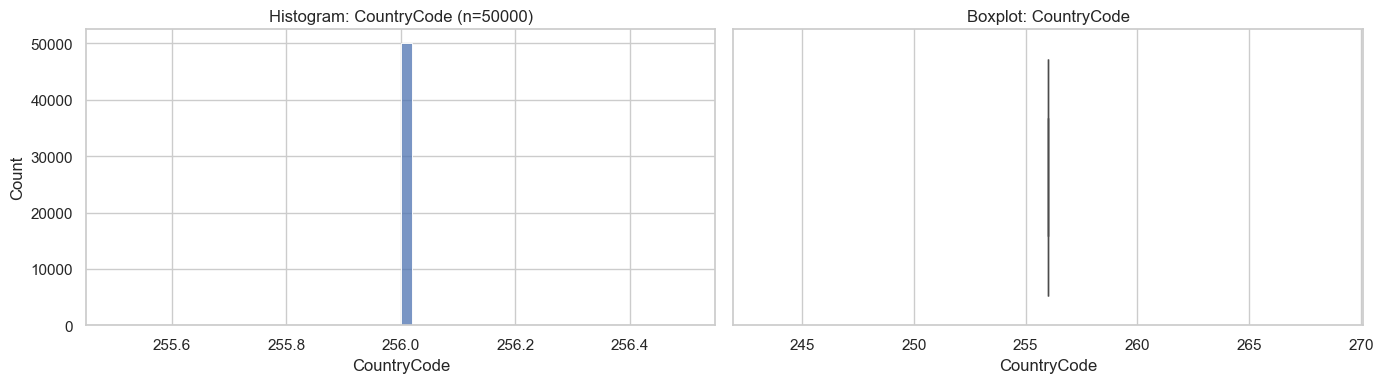

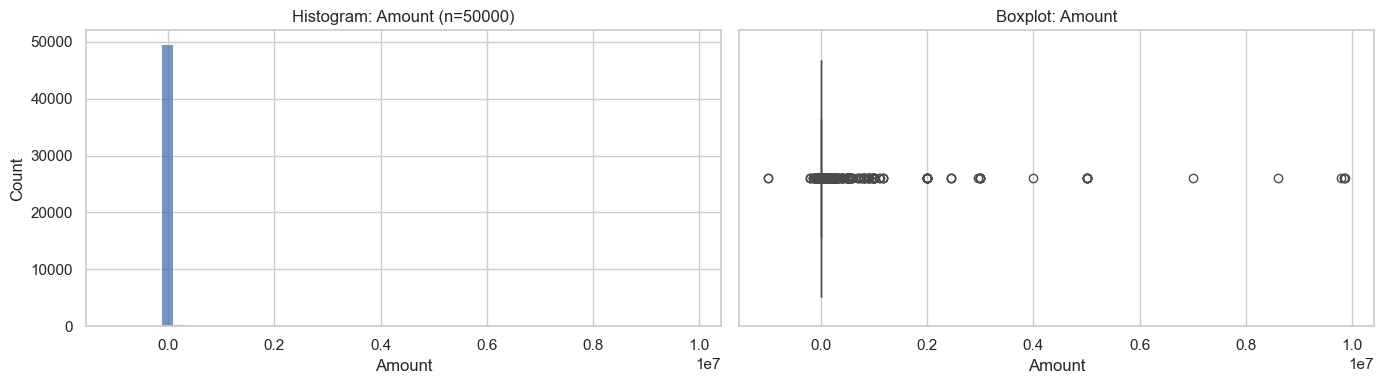

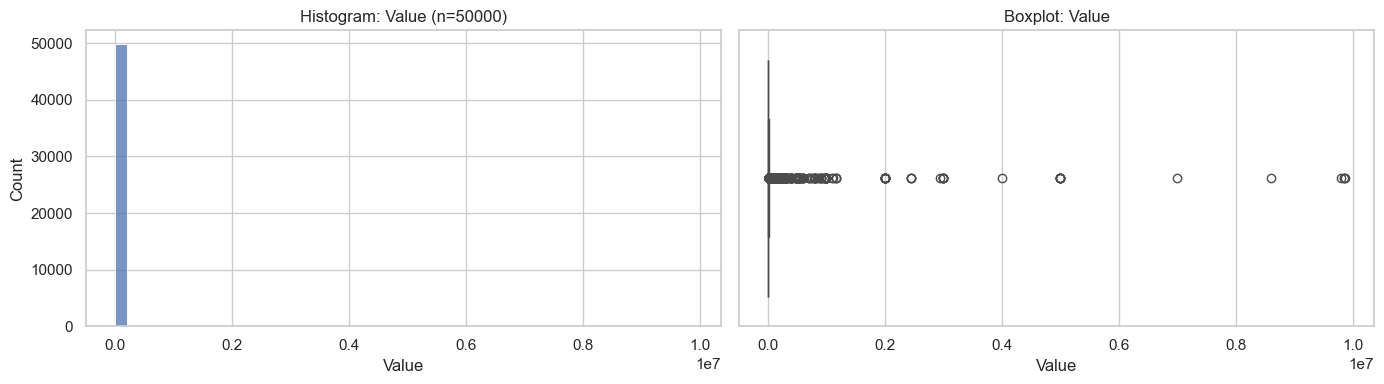

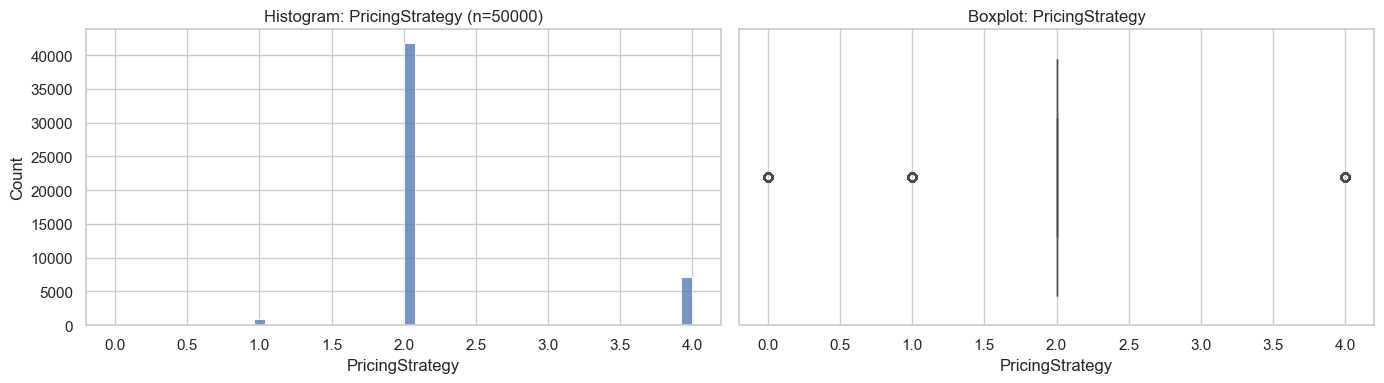

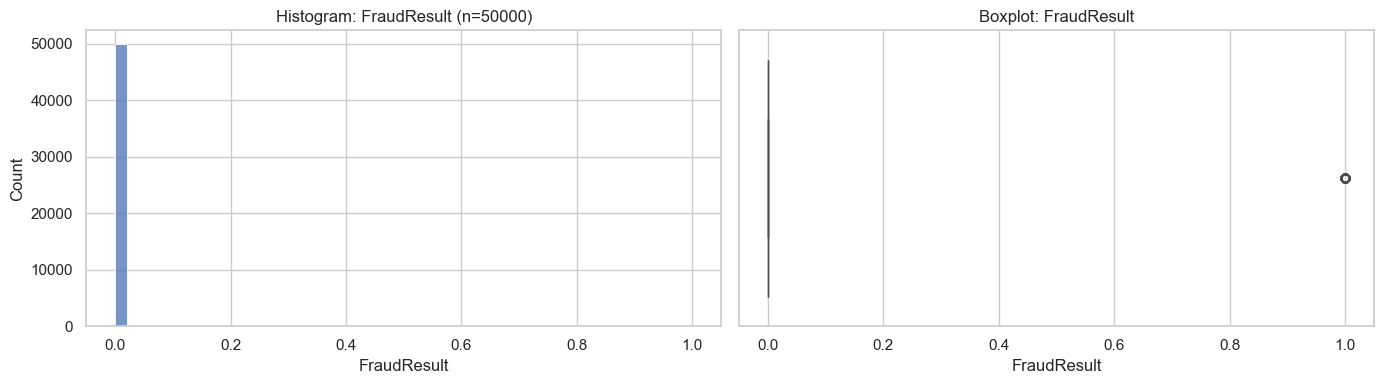

In [10]:
MAX_NUM_PLOTS = 6  # reduce if your kernel is slow
PLOT_KDE = False  # KDE is expensive; enable only if you really need it
BINS = 50

cols_to_plot = num_cols[:MAX_NUM_PLOTS]

for c in cols_to_plot:
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    # Histogram (optionally with KDE)
    sns.histplot(df_plot[c].dropna(), kde=PLOT_KDE, bins=BINS, ax=axes[0])
    axes[0].set_title(f"Histogram: {c} (n={len(df_plot)})")

    # Boxplot
    sns.boxplot(x=df_plot[c], ax=axes[1])
    axes[1].set_title(f"Boxplot: {c}")

    plt.tight_layout()
    plt.show()
    plt.close(fig)

## 5) Distribution of categorical features

We look for:

- High-cardinality columns (many unique values)
- Rare categories
- Potential grouping/encoding approaches

This plots up to `MAX_CAT_PLOTS` categorical columns.

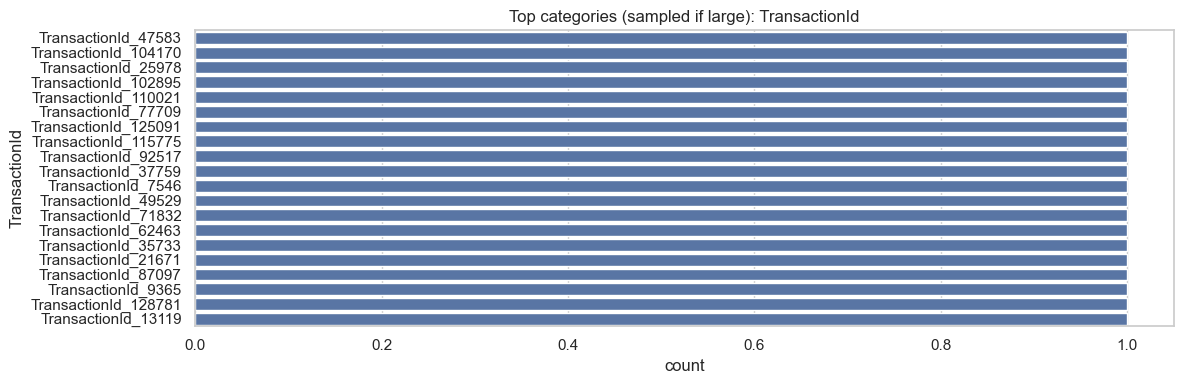

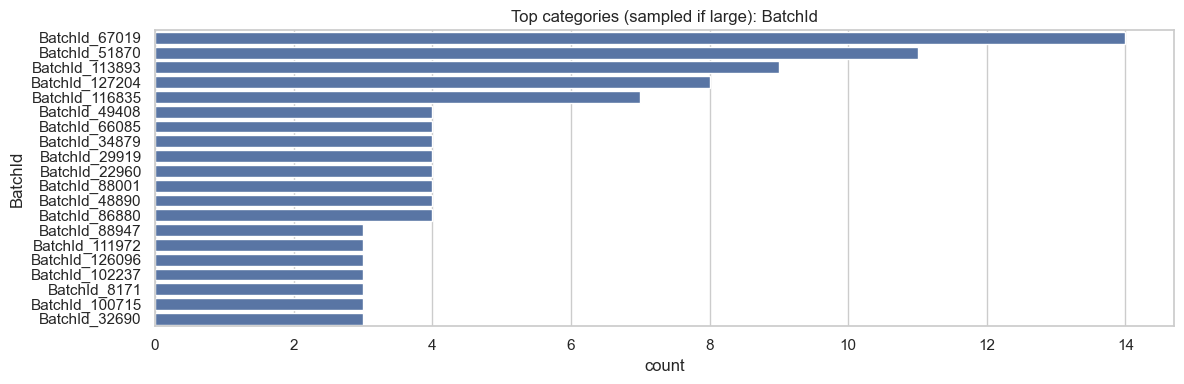

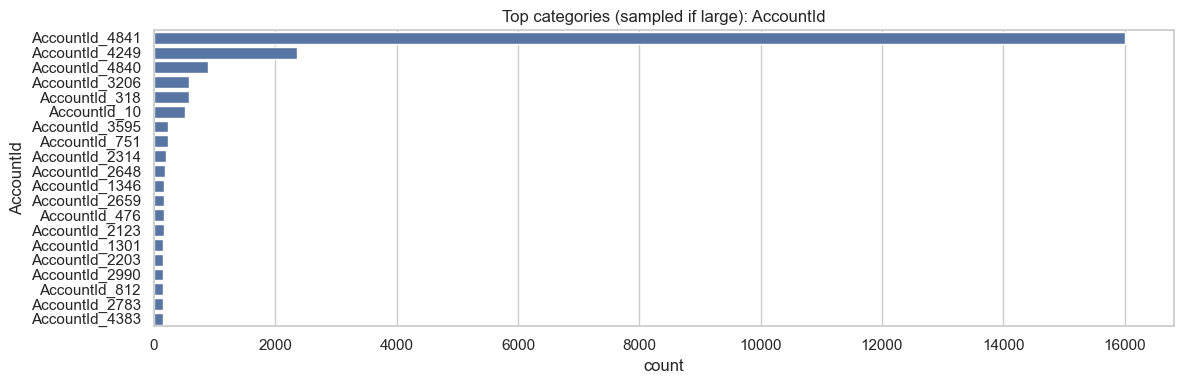

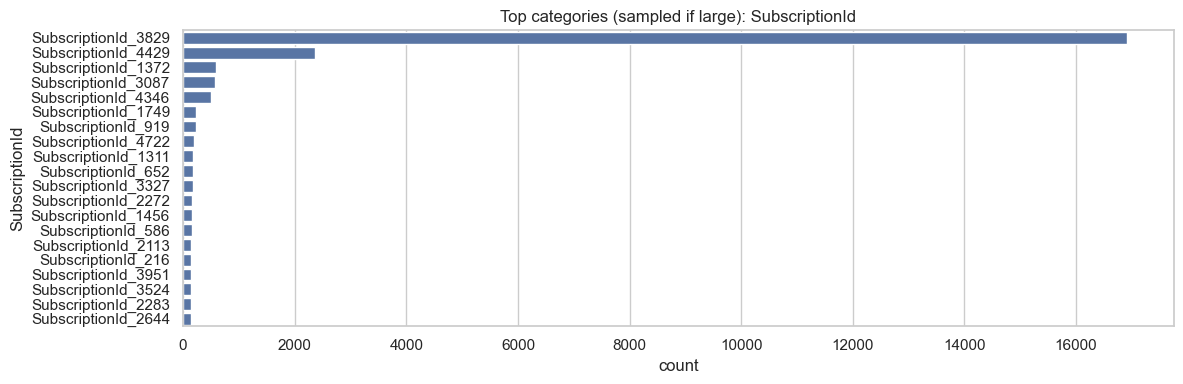

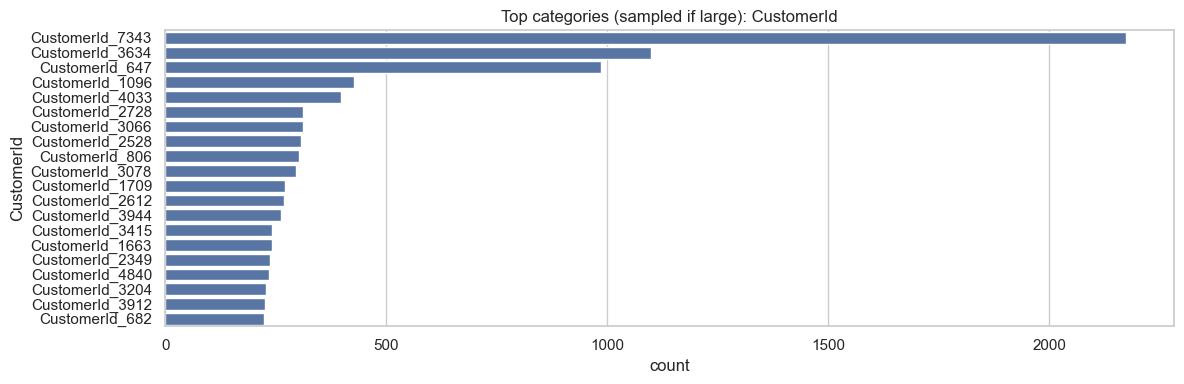

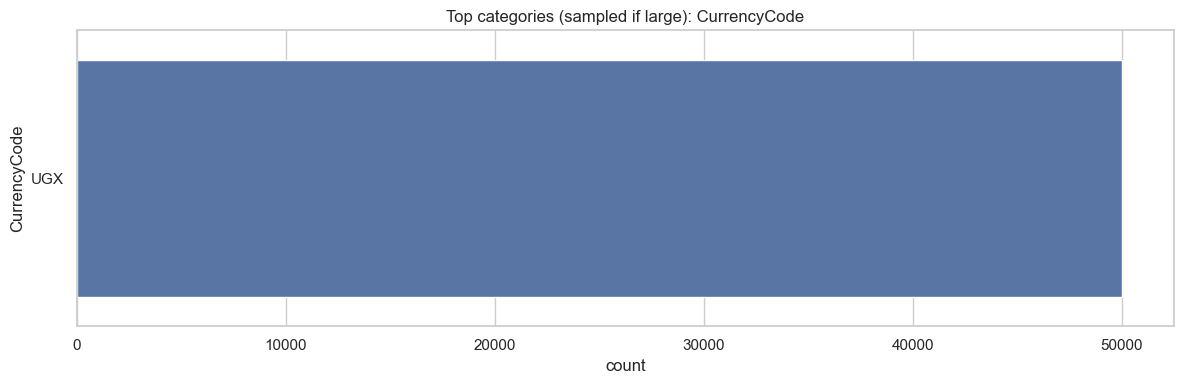

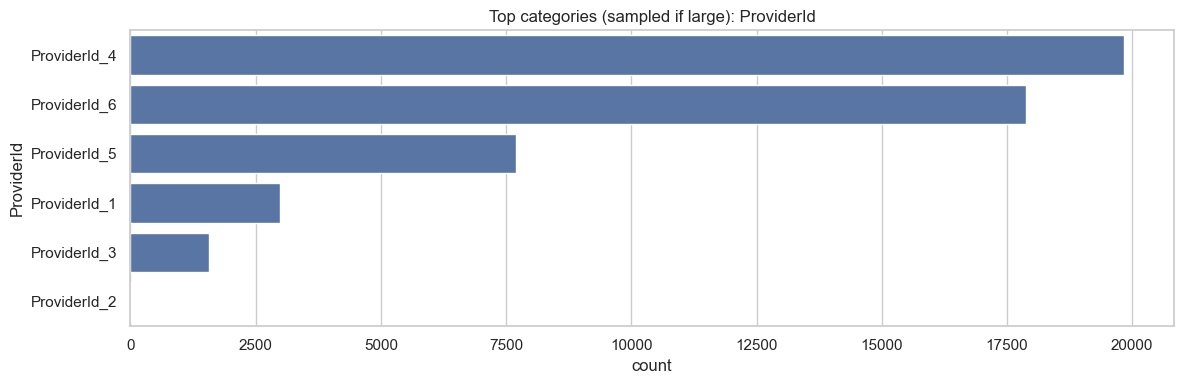

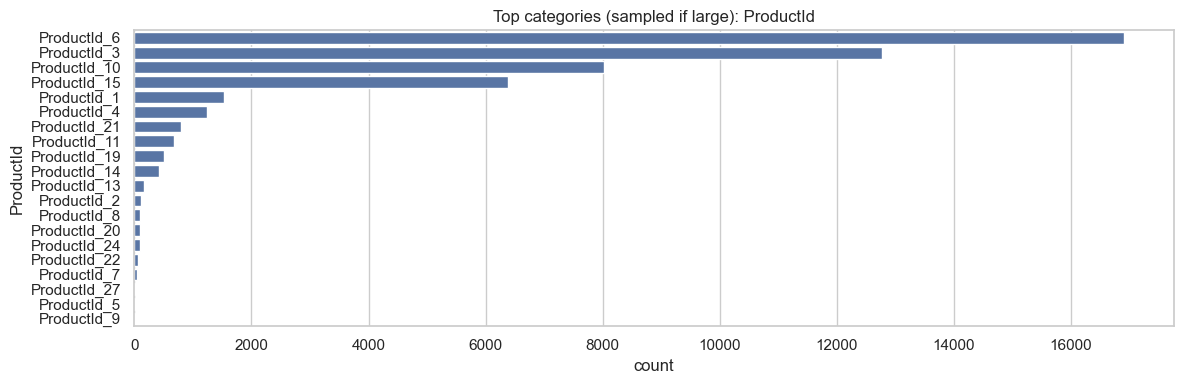

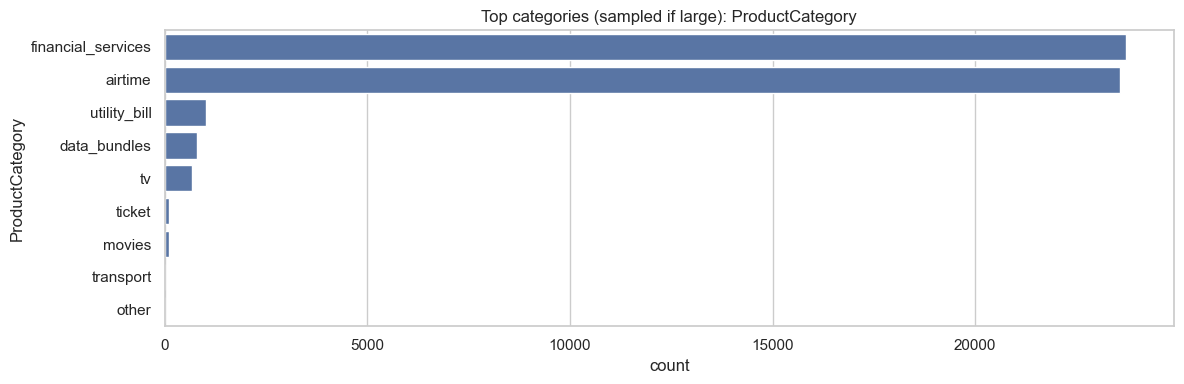

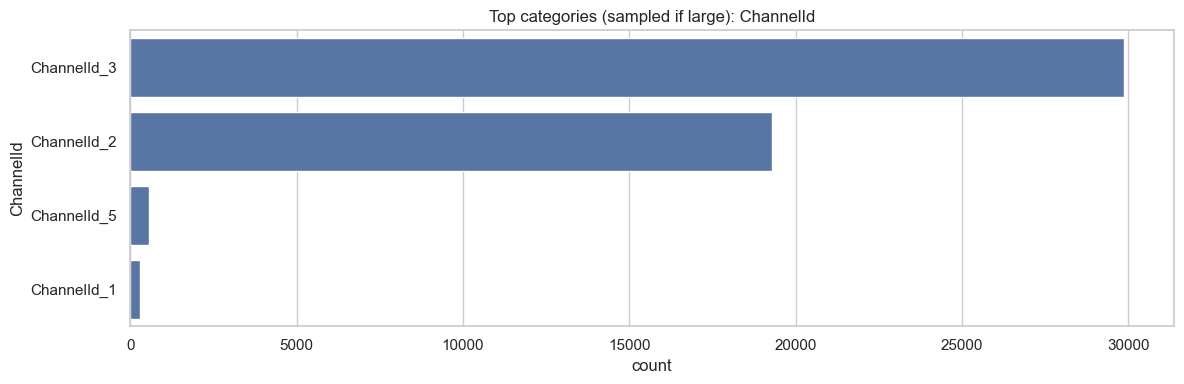

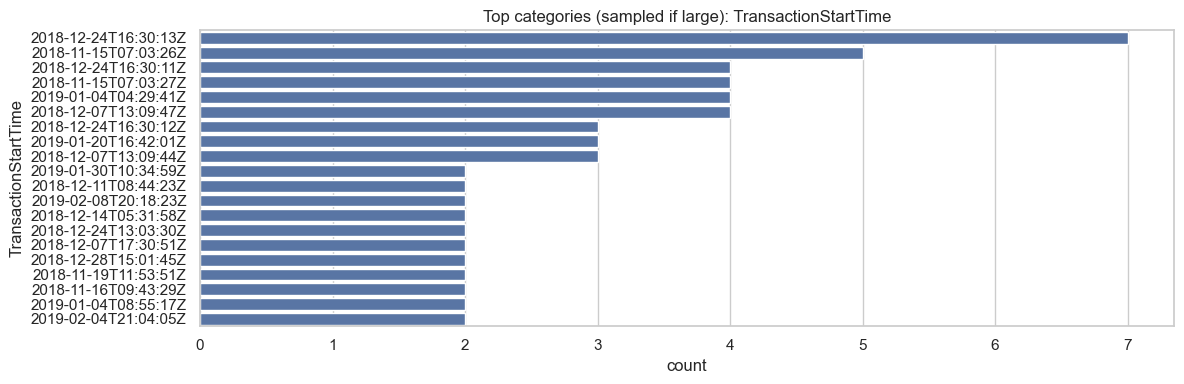

In [11]:
MAX_CAT_PLOTS = 12
cols_to_plot = cat_cols[:MAX_CAT_PLOTS]

for c in cols_to_plot:
    vc = df_plot[c].astype("string").fillna("<NA>").value_counts().head(20)
    plt.figure(figsize=(12, 4))
    sns.barplot(x=vc.values, y=vc.index)
    plt.title(f"Top categories (sampled if large): {c}")
    plt.xlabel("count")
    plt.ylabel(c)
    plt.tight_layout()
    plt.show()

## 6) Correlation analysis (numerical)

Correlation helps spot:

- Redundant features
- Strong linear relationships
- Multicollinearity risk (for linear models)

We compute correlations for numeric columns only.

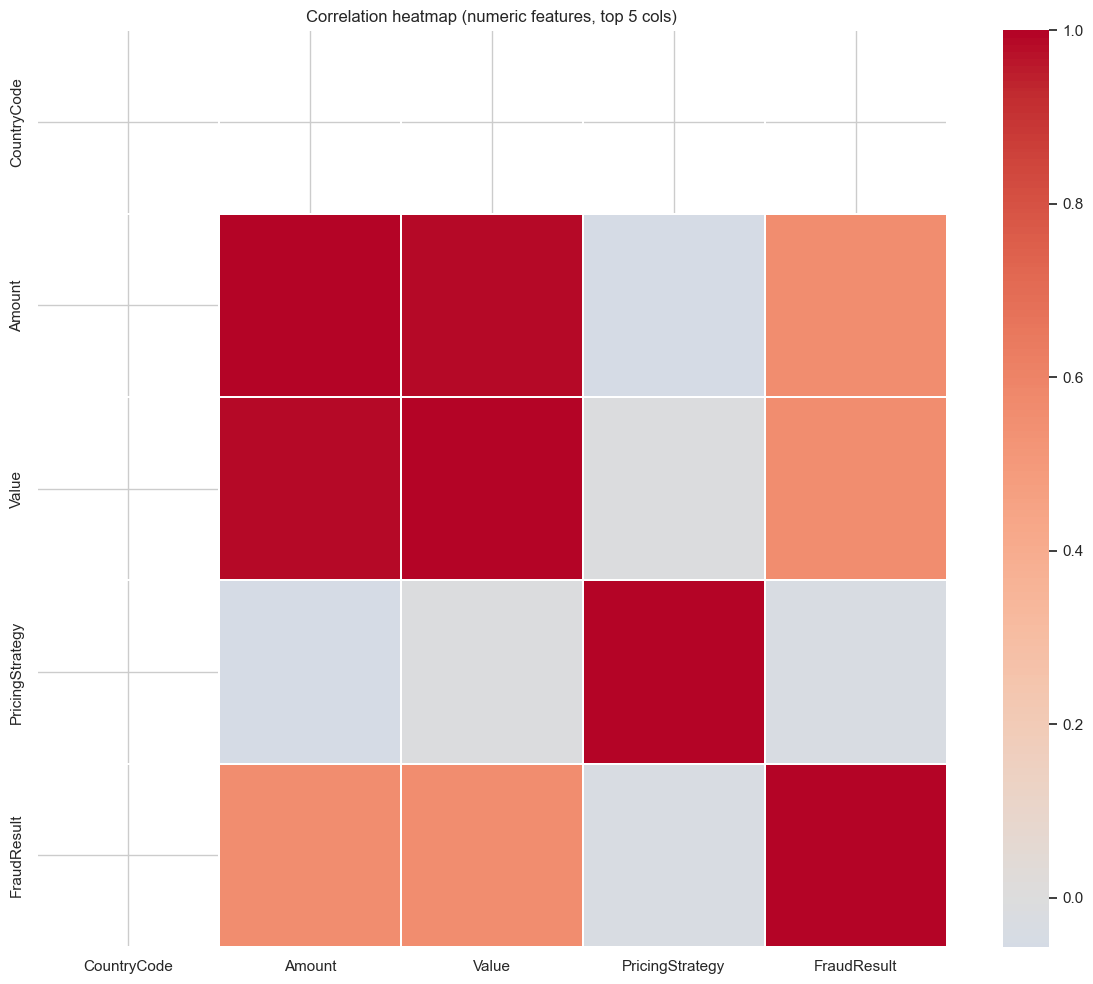

,feature_1,feature_2,abs_corr
0,Amount,Value,0.991019
1,Value,FraudResult,0.556794
2,Amount,FraudResult,0.556653
3,Amount,PricingStrategy,0.056854
4,PricingStrategy,FraudResult,0.029817
5,Value,PricingStrategy,0.014971


In [12]:
MAX_CORR_COLS = 40

if len(num_cols) >= 2:
    # Choose numeric columns with the most non-null values (simple heuristic)
    non_null_counts = df_plot[num_cols].notna().sum().sort_values(ascending=False)
    corr_cols = list(non_null_counts.head(MAX_CORR_COLS).index)

    corr = df_plot[corr_cols].corr(numeric_only=True)

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, cmap="coolwarm", center=0, linewidths=0.2)
    plt.title(f"Correlation heatmap (numeric features, top {len(corr_cols)} cols)")
    plt.tight_layout()
    plt.show()

    # Top absolute correlations (excluding self-correlation)
    corr_abs = corr.abs()
    upper = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))
    top_pairs = (
        upper.stack()
        .sort_values(ascending=False)
        .head(20)
        .reset_index()
        .rename(columns={"level_0": "feature_1", "level_1": "feature_2", 0: "abs_corr"})
    )
    display(top_pairs)
else:
    print("Not enough numeric columns for correlation analysis.")

## 7) Missing values

We summarize missingness to guide cleaning/imputation strategy.

,missing_pct,missing_count
TransactionId,0.0,0
BatchId,0.0,0
AccountId,0.0,0
SubscriptionId,0.0,0
CustomerId,0.0,0
CurrencyCode,0.0,0
CountryCode,0.0,0
ProviderId,0.0,0
ProductId,0.0,0
ProductCategory,0.0,0


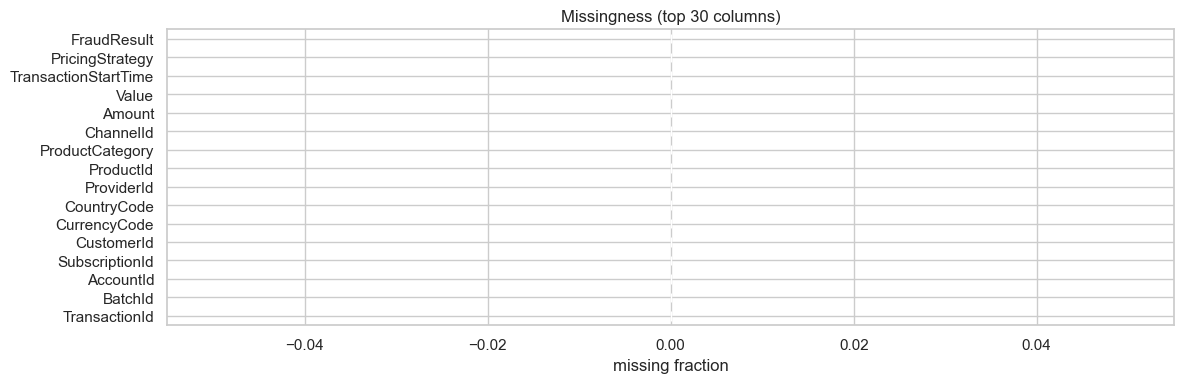

In [13]:
missing = df.isna().mean().sort_values(ascending=False)
missing_df = pd.DataFrame({"missing_pct": missing, "missing_count": df.isna().sum()})

display(missing_df.head(30))

plt.figure(figsize=(12, 4))
missing.head(30).sort_values().plot(kind="barh")
plt.title("Missingness (top 30 columns)")
plt.xlabel("missing fraction")
plt.tight_layout()
plt.show()

## 8) Outlier detection (IQR rule)

This computes a simple IQR-based outlier fraction per numeric column.

Note: outliers are not always errors in credit risk; they can be informative (e.g., high utilization).

In [14]:
def iqr_outlier_fraction(s: pd.Series) -> float:
    s = pd.to_numeric(s, errors="coerce").dropna()
    if s.empty:
        return 0.0
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    if iqr == 0:
        return 0.0
    lo = q1 - 1.5 * iqr
    hi = q3 + 1.5 * iqr
    return float(((s < lo) | (s > hi)).mean())

if num_cols:
    outlier_frac = pd.Series({c: iqr_outlier_fraction(df_plot[c]) for c in num_cols}).sort_values(ascending=False)
    display(outlier_frac.head(30).to_frame("iqr_outlier_fraction"))
else:
    print("No numeric columns found for outlier detection.")

,iqr_outlier_fraction
Amount,0.25690
Value,0.09742
CountryCode,0.00000
PricingStrategy,0.00000
FraudResult,0.00000


## 9) Top 3–5 most important insights (deliverable)

After running the notebook on your dataset, summarize your most important findings here (3–5 bullets).

Examples of good insights:

- Missingness is concentrated in specific columns and suggests a particular imputation strategy.
- Some numerical features are heavily skewed and may benefit from log transform / capping.
- Certain categorical features have extremely high cardinality and may require grouping.
- Strong correlations indicate redundant features or leakage risk.

In [15]:
# Helper cell: prints candidates for insights based on the computed summaries.

print("\nPotential insight starters")

# Missingness
if "missing_df" in globals():
    high_missing = missing_df[missing_df["missing_pct"] >= 0.3].head(10)
    if len(high_missing):
        print("\nColumns with >=30% missing (top 10):")
        display(high_missing)

# Outliers
if "outlier_frac" in globals() and len(outlier_frac):
    high_outliers = outlier_frac[outlier_frac >= 0.05].head(10)
    if len(high_outliers):
        print("\nColumns with >=5% IQR outliers (top 10):")
        display(high_outliers.to_frame("iqr_outlier_fraction"))

# High-cardinality categoricals (computed on df_plot to keep it responsive)
if len(cat_cols):
    high_card = pd.Series({c: df_plot[c].nunique(dropna=True) for c in cat_cols}).sort_values(ascending=False).head(10)
    print("\nHighest-cardinality categorical columns (top 10) [sampled if large]:")
    display(high_card.to_frame("n_unique"))


Potential insight starters

Columns with >=5% IQR outliers (top 10):


,iqr_outlier_fraction
Amount,0.25690
Value,0.09742



Highest-cardinality categorical columns (top 10) [sampled if large]:


,n_unique
TransactionId,50000
BatchId,49731
TransactionStartTime,49701
CustomerId,3289
AccountId,3084
SubscriptionId,3080
ProductId,22
ProductCategory,9
ProviderId,6
ChannelId,4
